<a href="https://colab.research.google.com/github/dileep9968/pytorch/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural network classificaiton with pytorch

### Make prediciton and evaluate the model

In [26]:
import requests
from pathlib import Path

# Download helper functin from learn pytorch repo
if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
  request = requests



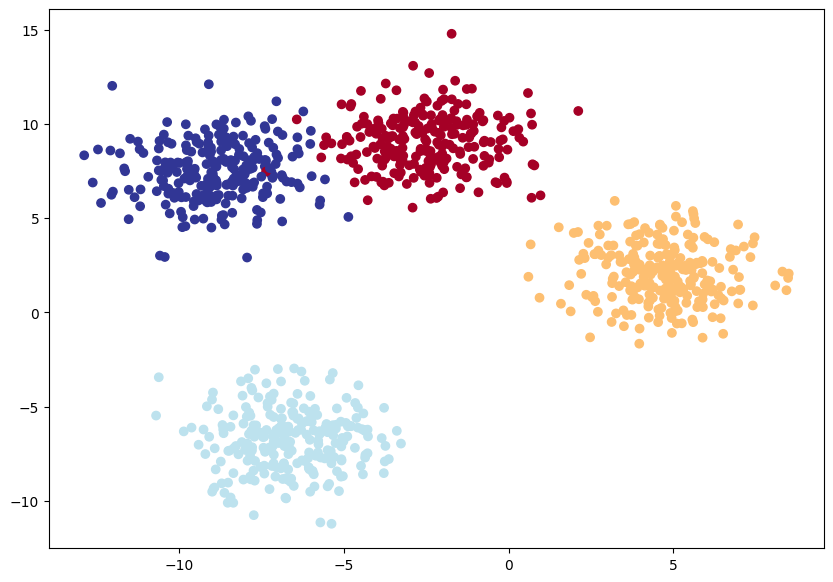

In [75]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameter for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# make the data
x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)
x_blob, y_blob = torch.from_numpy(x_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c = y_blob, cmap = plt.cm.RdYlBu)

### Building a multi-class classification

In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [77]:
class BlobModel(nn.Module):
  def __init__(self,input_features, output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features=hidden_units ),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features=hidden_units ),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features=output_features)
    )
  def forward(self,x:torch.Tensor):
    return self.linear_layer_stack(x)


In [78]:
model_blob = BlobModel(input_features = 2,
                       output_features = 4,
                       hidden_units=4).to(device)


In [79]:
model_blob

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [83]:
# setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_blob.parameters(),lr=0.1)

In [85]:
# trainin
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
x_train, y_train=x_blob_train.to(device),y_blob_train.to(device)
x_test, y_test = x_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  model_blob.train()
  y_logits = model_blob(x_train).squeeze()
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  #print(y_pred.dtype, y_train.dtype)
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_blob.eval()
  with torch.inference_mode():
    test_logits = model_blob(x_test).squeeze()
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_pred,y_test )

  if epoch %100==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")



Epoch: 0 | Loss: 0.02161, Acc: 99.38 | Test Loss: 0.01090, Test Acc: 99.50
Epoch: 100 | Loss: 0.02131, Acc: 99.38 | Test Loss: 0.01059, Test Acc: 99.50
Epoch: 200 | Loss: 0.02103, Acc: 99.38 | Test Loss: 0.01030, Test Acc: 99.50
Epoch: 300 | Loss: 0.02077, Acc: 99.38 | Test Loss: 0.01003, Test Acc: 99.50
Epoch: 400 | Loss: 0.02052, Acc: 99.38 | Test Loss: 0.00976, Test Acc: 99.50
Epoch: 500 | Loss: 0.02027, Acc: 99.38 | Test Loss: 0.00951, Test Acc: 99.50
Epoch: 600 | Loss: 0.02004, Acc: 99.38 | Test Loss: 0.00928, Test Acc: 99.50
Epoch: 700 | Loss: 0.01982, Acc: 99.38 | Test Loss: 0.00905, Test Acc: 99.50
Epoch: 800 | Loss: 0.01961, Acc: 99.38 | Test Loss: 0.00882, Test Acc: 99.50
Epoch: 900 | Loss: 0.01940, Acc: 99.50 | Test Loss: 0.00861, Test Acc: 99.50


In [71]:
y_pred.dtype

torch.int64

In [86]:
# Make prediction
model_blob.eval()
with torch.inference_mode():
  y_logits = model_blob(x_test).squeeze()
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
y_pred[:10],y_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

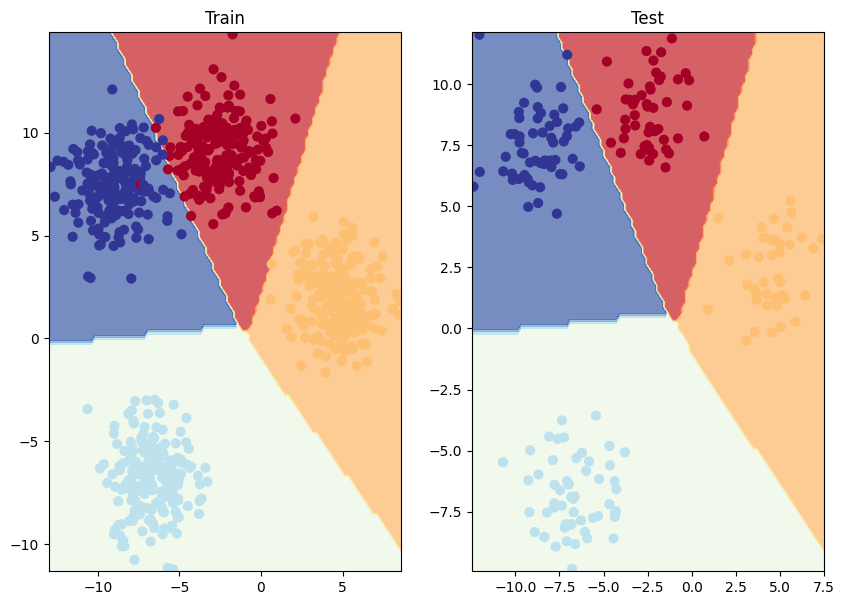

In [87]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_blob, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_blob,x_test,y_test)


### Evaludtion

In [88]:
#!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.6 MB/s eta 0:00:00


In [93]:
from torchmetrics import Accuracy
torchmetrics_acc = Accuracy(task='multiclass',num_classes =4).to(device)
torchmetrics_acc(y_pred,y_test)

tensor(0.9950, device='cuda:0')